### Analysis of Plasma proteomes based on MS1 and MS2 information

This jupyter notebook allows to analyze proteome discover output using exiting data from identified plasma proteins to re-score. 

In [28]:
import pandas as pd
import seaborn as sns
import re
import numpy as np 
import matplotlib.pyplot as plt

Load the public plasma proteome: 

**Gen**: Gen accession number
**Description**: Protein name
**Log_Conc**: Concentration Log2-based 
**Zscore**: Zscore per proteins
**Pvlue**: P value per proteins based on Zscore (probability in a normal distribution)

In [29]:
public_plasma_proteome = pd.read_csv("data/public-plasma-proteome.csv")
public_plasma_proteome.head()

,Gene,Description,Log_Conc,Zscore,PPvalue
0,ALB,Albumin,25.253497,4.531879,0.999997
1,CP,Ceruloplasmin,19.662752,3.489888,0.999758
2,GSN,Gelsolin,18.960138,3.358936,0.999609
3,RBP4,Retinol binding protein 4,18.680030,3.306730,0.999528
4,C3,Complement C3,17.931569,3.167234,0.999231


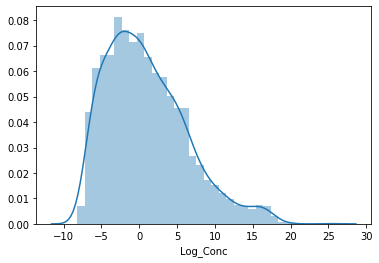

In [30]:
sns.distplot(public_plasma_proteome.Log_Conc)

Load internal database of plasma proteins: 

**Uniprot_Accession**: Uniprot accession 
**Pvalue**: P value based in the Zscore

In [31]:
inhouse_plasma_proteome = pd.read_csv("data/custom-plasma-proteome.csv")
inhouse_plasma_proteome.head()

,UniprotAccession,Pvalue
0,A0A075B6H7,0.380322
1,A0A075B6H9,0.493844
2,A0A075B6I0,0.590413
3,A0A075B6I1,0.238156
4,A0A075B6I4,0.238156


In [32]:
dataset = pd.read_csv("data/sample-example.csv")
dataset.head()

,UniprotAccession,Description,Globulins,PSMs,Abundance[S4],Abundance[S37],Abundance[S38],Abundance[S39],Abundance[S40],Abundance[S41],...,Found[S37],Found[S38],Found[S39],Found[S40],Found[S41],Found[S42],Found[S43],Found[S44],Found[S45],Gene
0,Q9Y3D6,Mitochondrial fission 1 protein OS=Homo sapien...,0,33,2.458242e+05,196345.65190,21321.138670,2643.908936,107823.93750,24494.51367,...,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,FIS1
1,Q6UY14,ADAMTS-like protein 4 OS=Homo sapiens OX=9606 ...,0,9,3.391171e+04,19308.35547,51113.827150,3389.173340,22343.27148,26381.99512,...,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,ADAMTSL4
2,O95340,Bifunctional 3'-phosphoadenosine 5'-phosphosul...,0,10,2.463229e+03,NaN,15918.753910,3854.183838,33735.15625,77540.17773,...,Not Found,Peak Found,Not Found,Peak Found,Peak Found,Peak Found,Peak Found,Not Found,Not Found,PAPSS2
3,Q96EI5,Transcription elongation factor A protein-like...,0,4,1.141564e+05,NaN,2213.285889,4548.162598,NaN,NaN,...,Not Found,Peak Found,Peak Found,Not Found,Not Found,Peak Found,Not Found,Not Found,Not Found,TCEAL4
4,Q9UBF2,Coatomer subunit gamma-2 OS=Homo sapiens OX=96...,0,47,5.057266e+06,NaN,77286.744140,5104.402832,95535.07031,453259.47270,...,Not Found,Peak Found,Not Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,COPG2


In [33]:
dataset = pd.merge(dataset, inhouse_plasma_proteome, on="UniprotAccession", how='outer')
dataset = pd.merge(dataset, public_plasma_proteome, on="Gene", how='outer')
dataset.head()

,UniprotAccession,Description_x,Globulins,PSMs,Abundance[S4],Abundance[S37],Abundance[S38],Abundance[S39],Abundance[S40],Abundance[S41],...,Found[S42],Found[S43],Found[S44],Found[S45],Gene,Pvalue,Description_y,Log_Conc,Zscore,PPvalue
0,Q9Y3D6,Mitochondrial fission 1 protein OS=Homo sapien...,0.0,33.0,2.458242e+05,196345.65190,21321.138670,2643.908936,107823.93750,24494.51367,...,Peak Found,Peak Found,Peak Found,Peak Found,FIS1,NaN,"Fission, mitochondrial 1",-0.761213,-0.316688,0.375740
1,Q6UY14,ADAMTS-like protein 4 OS=Homo sapiens OX=9606 ...,0.0,9.0,3.391171e+04,19308.35547,51113.827150,3389.173340,22343.27148,26381.99512,...,Peak Found,Peak Found,Peak Found,Peak Found,ADAMTSL4,0.400645,ADAMTS like 4,5.554589,0.860438,0.805226
2,O95340,Bifunctional 3'-phosphoadenosine 5'-phosphosul...,0.0,10.0,2.463229e+03,NaN,15918.753910,3854.183838,33735.15625,77540.17773,...,Peak Found,Peak Found,Not Found,Not Found,PAPSS2,NaN,NaN,NaN,NaN,NaN
3,Q96EI5,Transcription elongation factor A protein-like...,0.0,4.0,1.141564e+05,NaN,2213.285889,4548.162598,NaN,NaN,...,Peak Found,Not Found,Not Found,Not Found,TCEAL4,NaN,NaN,NaN,NaN,NaN
4,Q9UBF2,Coatomer subunit gamma-2 OS=Homo sapiens OX=96...,0.0,47.0,5.057266e+06,NaN,77286.744140,5104.402832,95535.07031,453259.47270,...,Peak Found,Peak Found,Peak Found,Peak Found,COPG2,NaN,Coatomer protein complex subunit gamma 2,-4.643856,-1.040326,0.149094


In [34]:
def compute_probability(row, sample):
    abundance = row['Pvalue'] + row['PPvalue'] - (row['Pvalue'] * row['PPvalue'])
    if np.isnan(row['Pvalue']) or np.isnan(row['PPvalue']):
        abundance = 0.009

    if row['Found[' + sample + ']'] == 'High':
        abundance = 1 * row['Abundance[' + sample + ']']
    if row['Found[' + sample + ']'] == 'Peak Found':
        abundance = abundance * row['Abundance[' + sample + ']']

    return abundance


samples = []
for column in list(dataset.columns.values):
    m = re.search(r"\[([A-Za-z0-9_]+)\]", column)
    if m is not None and (len(m.group(1))):
        samples.append(m.group(1))

samples = np.unique(np.array(samples))
for sample in samples:
    dataset['AbundanceRecall[' + sample + ']'] = dataset.apply(lambda row: compute_probability(row, sample), axis=1)
dataset.head()

,UniprotAccession,Description_x,Globulins,PSMs,Abundance[S4],Abundance[S37],Abundance[S38],Abundance[S39],Abundance[S40],Abundance[S41],...,AbundanceRecall[S37],AbundanceRecall[S38],AbundanceRecall[S39],AbundanceRecall[S4],AbundanceRecall[S40],AbundanceRecall[S41],AbundanceRecall[S42],AbundanceRecall[S43],AbundanceRecall[S44],AbundanceRecall[S45]
0,Q9Y3D6,Mitochondrial fission 1 protein OS=Homo sapien...,0.0,33.0,2.458242e+05,196345.65190,21321.138670,2643.908936,107823.93750,24494.51367,...,1767.110867,191.890248,23.795180,2212.417758,970.415437,220.450623,236.413002,17.210510,1642.858219,1284.325460
1,Q6UY14,ADAMTS-like protein 4 OS=Homo sapiens OX=9606 ...,0.0,9.0,3.391171e+04,19308.35547,51113.827150,3389.173340,22343.27148,26381.99512,...,17054.325658,45146.872048,2993.526090,29952.909735,19734.949912,23302.198729,23565.834150,54077.572571,73593.402706,18232.779479
2,O95340,Bifunctional 3'-phosphoadenosine 5'-phosphosul...,0.0,10.0,2.463229e+03,NaN,15918.753910,3854.183838,33735.15625,77540.17773,...,0.009000,143.268785,0.009000,0.009000,303.616406,697.861600,428.363282,251.641107,0.009000,0.009000
3,Q96EI5,Transcription elongation factor A protein-like...,0.0,4.0,1.141564e+05,NaN,2213.285889,4548.162598,NaN,NaN,...,0.009000,19.919573,40.933463,1027.407164,0.009000,0.009000,53.315512,0.009000,0.009000,0.009000
4,Q9UBF2,Coatomer subunit gamma-2 OS=Homo sapiens OX=96...,0.0,47.0,5.057266e+06,NaN,77286.744140,5104.402832,95535.07031,453259.47270,...,0.009000,695.580697,0.009000,45515.391678,859.815633,4079.335254,9006.238692,775.108441,1704.189058,2171.404371


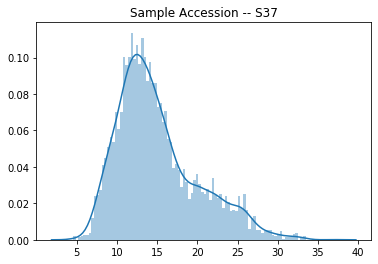

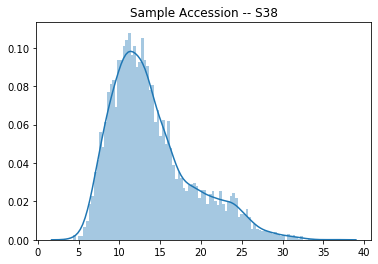

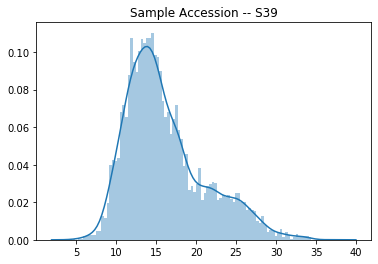

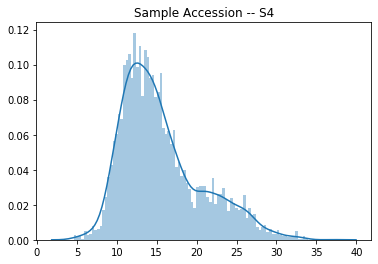

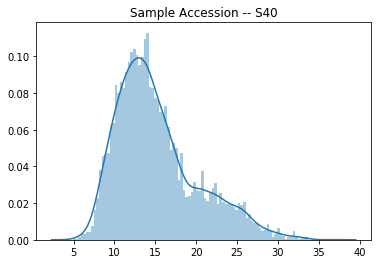

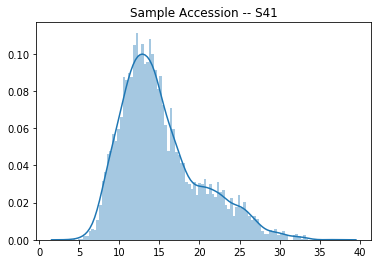

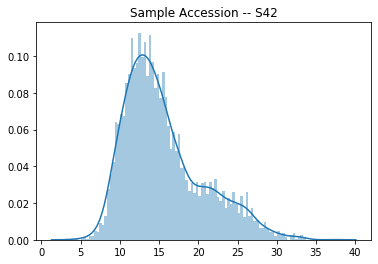

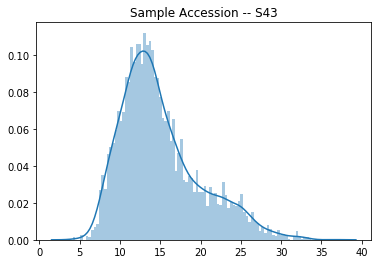

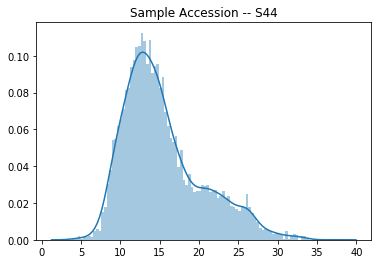

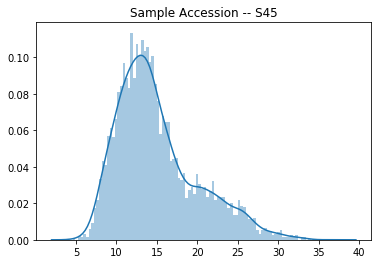

In [47]:
for sample in samples: 
    values = dataset['AbundanceRecall[' + sample + ']'].to_list()
    values = sorted(i for i in values if i >= 1)
    values = np.log2(values)
    plt.figure() #this creates a new figure on which your plot will appear
    ax = plt.axes()
    sns.distplot(values,bins = 100, ax = ax) 
    ax.set_title('Sample Accession -- ' + sample)
    
    